In [2]:
from __future__ import print_function
import os
import argparse
import sys
import cv2
import warnings
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm

warnings.simplefilter("ignore")

In [3]:
def overlay_contoures_on_org_image(image, contoure, img_poly, experimnet, overlay):

    if experimnet == "textline":
        overlayed_textlines_detection = np.zeros(img_poly.shape)

        for cnts in contoure:
            image_help = np.zeros(img_poly.shape)
            image_help = cv2.fillPoly(image_help, pts=[cnts], color=(1, 1, 1))

            overlayed_textlines_detection[:, :, :] = (
                overlayed_textlines_detection[:, :, :] + image_help[:, :, :]
            )

        overlayed_textlines_detection[:, :, 0][
            overlayed_textlines_detection[:, :, 0] > 2
        ] = 2

        overlayed_textlines_detection_2 = np.copy(overlayed_textlines_detection)

        overlayed_textlines_detection = (
            (overlayed_textlines_detection[:, :, :] == 1)
        ) * 1

        overlayed_textlines_detection = overlayed_textlines_detection.astype(np.uint8)
        imgray = cv2.cvtColor(overlayed_textlines_detection, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray, 0, 255, 0)

        contours_lines, hierachy = cv2.findContours(
            thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )

        overlayed_textlines_detection_2 = (
            (overlayed_textlines_detection_2[:, :, :] == 2)
        ) * 1

        overlayed_textlines_detection_2 = overlayed_textlines_detection_2.astype(
            np.uint8
        )
        imgray = cv2.cvtColor(overlayed_textlines_detection_2, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray, 0, 255, 0)

        contours_lines_overlapped, hierachy = cv2.findContours(
            thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )

        overlay1 = image.copy()
        overlay2 = image.copy()
        output = image.copy()

        overlay1 = cv2.fillPoly(overlay1, pts=contours_lines, color=(255, 0, 0))
        overlay2 = cv2.fillPoly(
        overlay2, pts=contours_lines_overlapped, color=(255, 0, 0)
        )

        alpha1 = 0.2
        alpha2 = 0.4
        cv2.addWeighted(overlay1, alpha1, output, 1 - alpha1, 0, output)
        cv2.addWeighted(overlay2, alpha2, output, 1 - alpha2, 0, output)
        plt.figure(figsize=(40, 40))
        plt.imshow(output)

    else:

        output = image.copy()
        alpha = 0.2
        cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
        plt.figure(figsize=(40, 40))
        plt.imshow(output)

In [4]:
def get_regions_contours_back(experiment, dir_of_xml_data, image):
    tree1 = ET.parse(dir_of_xml_data)
    root1 = tree1.getroot()
    alltags = [elem.tag for elem in root1.iter()]
    link = alltags[0].split("}")[0] + "}"

    for jj in root1.iter(link + "Page"):
        y_len = int(jj.attrib["imageHeight"])
        x_len = int(jj.attrib["imageWidth"])
    if experiment == "textline":
        region_tags = np.unique([x for x in alltags if x.endswith("TextLine")])
        co_line = []
        # print('vaaaiiii')
        for tag in region_tags:
            if tag.endswith("}TextLine") or tag.endswith("}textline"):
                # print('sth')
                for nn in root1.iter(tag):
                    c_t_in = []
                    sumi = 0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag == link + "Coords":
                            coords = bool(vv.attrib)
                            if coords:
                                p_h = vv.attrib["points"].split(" ")
                                c_t_in.append(
                                    np.array(
                                        [
                                            [int(x.split(",")[0]), int(x.split(",")[1])]
                                            for x in p_h
                                        ]
                                    )
                                )
                                break
                            else:
                                pass

                        if vv.tag == link + "Point":
                            c_t_in.append(
                                [
                                    int(np.float(vv.attrib["x"])),
                                    int(np.float(vv.attrib["y"])),
                                ]
                            )
                            sumi += 1
                        # print(vv.tag,'in')
                        elif vv.tag != link + "Point" and sumi >= 1:
                            break
                    co_line.append(np.array(c_t_in))

        img = np.zeros((y_len, x_len, 3))
        img_poly = cv2.fillPoly(img, pts=co_line, color=(255, 0, 0))

        # try:
        #    cv2.imwrite(self.output_dir+'/'+self.gt_list[index].split('-')[1].split('.')[0]+'.png',img_poly )
        # except:
        #    cv2.imwrite(self.output_dir+'/'+self.gt_list[index].split('.')[0]+'.png',img_poly )

        overlay = None

    elif experiment == "layout":
        region_tags = np.unique([x for x in alltags if x.endswith("Region")])

        co_text_paragraph = []
        co_text_drop = []
        co_text_heading = []
        co_text_header = []
        co_text_marginalia = []
        co_text_catch = []
        co_text_page_number = []
        co_text_signature_mark = []
        co_sep = []
        co_img = []
        co_table = []
        co_graphic = []
        co_graphic_text_annotation = []
        co_graphic_decoration = []
        co_noise = []

        for tag in region_tags:
            if tag.endswith("}TextRegion") or tag.endswith("}Textregion"):
                for nn in root1.iter(tag):
                    c_t_in_drop = []
                    c_t_in_paragraph = []
                    c_t_in_heading = []
                    c_t_in_header = []
                    c_t_in_page_number = []
                    c_t_in_signature_mark = []
                    c_t_in_catch = []
                    c_t_in_marginalia = []
                    sumi = 0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag == link + "Coords":

                            coords = bool(vv.attrib)
                            if coords:
                                # print('birda1')
                                p_h = vv.attrib["points"].split(" ")

                                if (
                                    "type" in nn.attrib
                                    and nn.attrib["type"] == "drop-capital"
                                ):
                                    # if nn.attrib['type']=='paragraph':

                                    c_t_in_drop.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )

                                elif (
                                    "type" in nn.attrib
                                    and nn.attrib["type"] == "heading"
                                ):
                                    c_t_in_heading.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )

                                elif (
                                    "type" in nn.attrib
                                    and nn.attrib["type"] == "signature-mark"
                                ):

                                    c_t_in_signature_mark.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )
                                    # print(c_t_in_paragraph)
                                elif (
                                    "type" in nn.attrib
                                    and nn.attrib["type"] == "header"
                                ):
                                    c_t_in_header.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )

                                elif (
                                    "type" in nn.attrib
                                    and nn.attrib["type"] == "catch-word"
                                ):
                                    c_t_in_catch.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )

                                elif (
                                    "type" in nn.attrib
                                    and nn.attrib["type"] == "page-number"
                                ):

                                    c_t_in_page_number.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )
                                    # print(c_t_in_paragraph)

                                elif (
                                    "type" in nn.attrib
                                    and nn.attrib["type"] == "marginalia"
                                ):

                                    c_t_in_marginalia.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )
                                    # print(c_t_in_paragraph)
                                else:

                                    c_t_in_paragraph.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )
                                    # print(c_t_in_paragraph)

                                break
                            else:
                                pass

                        if vv.tag == link + "Point":
                            if (
                                "type" in nn.attrib
                                and nn.attrib["type"] == "drop-capital"
                            ):
                                # if nn.attrib['type']=='paragraph':

                                c_t_in_drop.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                sumi += 1

                            elif "type" in nn.attrib and nn.attrib["type"] == "heading":
                                c_t_in_heading.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                sumi += 1

                            elif (
                                "type" in nn.attrib
                                and nn.attrib["type"] == "signature-mark"
                            ):

                                c_t_in_signature_mark.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                # print(c_t_in_paragraph)
                                sumi += 1
                            elif "type" in nn.attrib and nn.attrib["type"] == "header":
                                c_t_in_header.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                sumi += 1

                            elif (
                                "type" in nn.attrib
                                and nn.attrib["type"] == "catch-word"
                            ):
                                c_t_in_catch.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                sumi += 1

                            elif (
                                "type" in nn.attrib
                                and nn.attrib["type"] == "page-number"
                            ):

                                c_t_in_page_number.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                # print(c_t_in_paragraph)
                                sumi += 1

                            elif (
                                "type" in nn.attrib
                                and nn.attrib["type"] == "marginalia"
                            ):

                                c_t_in_marginalia.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                # print(c_t_in_paragraph)
                                sumi += 1

                            else:
                                c_t_in_paragraph.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                # print(c_t_in_paragraph)
                                sumi += 1

                            # c_t_in.append([ int(np.float(vv.attrib['x'])) , int(np.float(vv.attrib['y'])) ])

                        # print(vv.tag,'in')
                        elif vv.tag != link + "Point" and sumi >= 1:
                            break

                    if len(c_t_in_drop) > 0:
                        co_text_drop.append(np.array(c_t_in_drop))
                    if len(c_t_in_paragraph) > 0:
                        co_text_paragraph.append(np.array(c_t_in_paragraph))
                    if len(c_t_in_heading) > 0:
                        co_text_heading.append(np.array(c_t_in_heading))

                    if len(c_t_in_header) > 0:
                        co_text_header.append(np.array(c_t_in_header))
                    if len(c_t_in_page_number) > 0:
                        co_text_page_number.append(np.array(c_t_in_page_number))
                    if len(c_t_in_catch) > 0:
                        co_text_catch.append(np.array(c_t_in_catch))

                    if len(c_t_in_signature_mark) > 0:
                        co_text_signature_mark.append(np.array(c_t_in_signature_mark))

                    if len(c_t_in_marginalia) > 0:
                        co_text_marginalia.append(np.array(c_t_in_marginalia))

            elif tag.endswith("}GraphicRegion") or tag.endswith("}graphicregion"):
                # print('sth')
                for nn in root1.iter(tag):
                    c_t_in = []
                    c_t_in_text_annotation = []
                    c_t_in_decoration = []
                    sumi = 0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag == link + "Coords":
                            coords = bool(vv.attrib)
                            if coords:
                                p_h = vv.attrib["points"].split(" ")
                                # c_t_in.append( np.array( [ [ int(x.split(',')[0]) , int(x.split(',')[1]) ]  for x in p_h] ) )

                                if (
                                    "type" in nn.attrib
                                    and nn.attrib["type"] == "handwritten-annotation"
                                ):
                                    # if nn.attrib['type']=='paragraph':

                                    c_t_in_text_annotation.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )

                                elif (
                                    "type" in nn.attrib
                                    and nn.attrib["type"] == "decoration"
                                ):

                                    c_t_in_decoration.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )
                                    # print(c_t_in_paragraph)
                                else:
                                    c_t_in.append(
                                        np.array(
                                            [
                                                [
                                                    int(x.split(",")[0]),
                                                    int(x.split(",")[1]),
                                                ]
                                                for x in p_h
                                            ]
                                        )
                                    )

                                break
                            else:
                                pass

                        if vv.tag == link + "Point":

                            if (
                                "type" in nn.attrib
                                and nn.attrib["type"] == "handwritten-annotation"
                            ):
                                # if nn.attrib['type']=='paragraph':

                                c_t_in_text_annotation.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                sumi += 1

                            elif (
                                "type" in nn.attrib
                                and nn.attrib["type"] == "decoration"
                            ):

                                c_t_in_decoration.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                # print(c_t_in_paragraph)
                                sumi += 1
                            else:
                                c_t_in.append(
                                    [
                                        int(np.float(vv.attrib["x"])),
                                        int(np.float(vv.attrib["y"])),
                                    ]
                                )
                                sumi += 1

                    if len(c_t_in_text_annotation) > 0:
                        co_graphic_text_annotation.append(
                            np.array(c_t_in_text_annotation)
                        )
                    if len(c_t_in_decoration) > 0:
                        co_graphic_decoration.append(np.array(c_t_in_decoration))
                    if len(c_t_in) > 0:
                        co_graphic.append(np.array(c_t_in))

            elif tag.endswith("}ImageRegion") or tag.endswith("}imageregion"):
                # print('sth')
                for nn in root1.iter(tag):
                    c_t_in = []
                    sumi = 0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag == link + "Coords":
                            coords = bool(vv.attrib)
                            if coords:
                                p_h = vv.attrib["points"].split(" ")
                                c_t_in.append(
                                    np.array(
                                        [
                                            [int(x.split(",")[0]), int(x.split(",")[1])]
                                            for x in p_h
                                        ]
                                    )
                                )
                                break
                            else:
                                pass

                        if vv.tag == link + "Point":
                            c_t_in.append(
                                [
                                    int(np.float(vv.attrib["x"])),
                                    int(np.float(vv.attrib["y"])),
                                ]
                            )
                            sumi += 1
                        # print(vv.tag,'in')
                        elif vv.tag != link + "Point" and sumi >= 1:
                            break
                    co_img.append(np.array(c_t_in))

            elif tag.endswith("}SeparatorRegion") or tag.endswith("}separatorregion"):
                # print('sth')
                for nn in root1.iter(tag):
                    c_t_in = []
                    sumi = 0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag == link + "Coords":
                            coords = bool(vv.attrib)
                            if coords:
                                p_h = vv.attrib["points"].split(" ")
                                c_t_in.append(
                                    np.array(
                                        [
                                            [int(x.split(",")[0]), int(x.split(",")[1])]
                                            for x in p_h
                                        ]
                                    )
                                )
                                break
                            else:
                                pass

                        if vv.tag == link + "Point":
                            c_t_in.append(
                                [
                                    int(np.float(vv.attrib["x"])),
                                    int(np.float(vv.attrib["y"])),
                                ]
                            )
                            sumi += 1
                        # print(vv.tag,'in')
                        elif vv.tag != link + "Point" and sumi >= 1:
                            break
                    co_sep.append(np.array(c_t_in))

            elif tag.endswith("}TableRegion") or tag.endswith("}tableregion"):
                # print('sth')
                for nn in root1.iter(tag):
                    c_t_in = []
                    sumi = 0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag == link + "Coords":
                            coords = bool(vv.attrib)
                            if coords:
                                p_h = vv.attrib["points"].split(" ")
                                c_t_in.append(
                                    np.array(
                                        [
                                            [int(x.split(",")[0]), int(x.split(",")[1])]
                                            for x in p_h
                                        ]
                                    )
                                )
                                break
                            else:
                                pass

                        if vv.tag == link + "Point":
                            c_t_in.append(
                                [
                                    int(np.float(vv.attrib["x"])),
                                    int(np.float(vv.attrib["y"])),
                                ]
                            )
                            sumi += 1
                        # print(vv.tag,'in')
                        elif vv.tag != link + "Point" and sumi >= 1:
                            break
                    co_table.append(np.array(c_t_in))

            elif tag.endswith("}NoiseRegion") or tag.endswith("}noiseregion"):
                # print('sth')
                for nn in root1.iter(tag):
                    c_t_in = []
                    sumi = 0
                    for vv in nn.iter():
                        # check the format of coords
                        if vv.tag == link + "Coords":
                            coords = bool(vv.attrib)
                            if coords:
                                p_h = vv.attrib["points"].split(" ")
                                c_t_in.append(
                                    np.array(
                                        [
                                            [int(x.split(",")[0]), int(x.split(",")[1])]
                                            for x in p_h
                                        ]
                                    )
                                )
                                break
                            else:
                                pass

                        if vv.tag == link + "Point":
                            c_t_in.append(
                                [
                                    int(np.float(vv.attrib["x"])),
                                    int(np.float(vv.attrib["y"])),
                                ]
                            )
                            sumi += 1
                        # print(vv.tag,'in')
                        elif vv.tag != link + "Point" and sumi >= 1:
                            break
                    co_noise.append(np.array(c_t_in))

        # img = np.zeros( (y_len,x_len,3) )

        overlay = image.copy()

        overlay = cv2.fillPoly(overlay, pts=co_text_paragraph, color=(255, 0, 0))
        overlay = cv2.fillPoly(overlay, pts=co_text_heading, color=(255, 125, 0))
        overlay = cv2.fillPoly(overlay, pts=co_text_header, color=(255, 0, 125))
        overlay = cv2.fillPoly(overlay, pts=co_text_catch, color=(125, 255, 125))
        overlay = cv2.fillPoly(overlay, pts=co_text_signature_mark, color=(125, 125, 0))
        overlay = cv2.fillPoly(overlay, pts=co_graphic_decoration, color=(0, 125, 255))
        overlay = cv2.fillPoly(overlay, pts=co_text_page_number, color=(0, 125, 0))
        overlay = cv2.fillPoly(overlay, pts=co_text_marginalia, color=(125, 125, 125))
        overlay = cv2.fillPoly(overlay, pts=co_text_drop, color=(0, 125, 255))
        overlay = cv2.fillPoly(overlay, pts=co_graphic_text_annotation, color=(125, 0, 125))
        overlay = cv2.fillPoly(overlay, pts=co_img, color=(0, 255, 0))
        overlay = cv2.fillPoly(overlay, pts=co_sep, color=(0, 0, 255))
        overlay = cv2.fillPoly(overlay, pts=co_table, color=(0, 255, 255))
        overlay = cv2.fillPoly(overlay, pts=co_graphic, color=(255, 125, 125))
        overlay = cv2.fillPoly(overlay, pts=co_noise, color=(255, 0, 255))

        co_line = None
        img_poly = None
    return co_line, img_poly, experiment, overlay


In [5]:
def run_every_thing(dir_of_xml_data, dir_of_image, experiment):
    image = cv2.imread(dir_of_image)

    co_line, img_poly, experiment, overlay = get_regions_contours_back(experiment, dir_of_xml_data, image)
    overlay_contoures_on_org_image(image, co_line, img_poly, experiment, overlay)


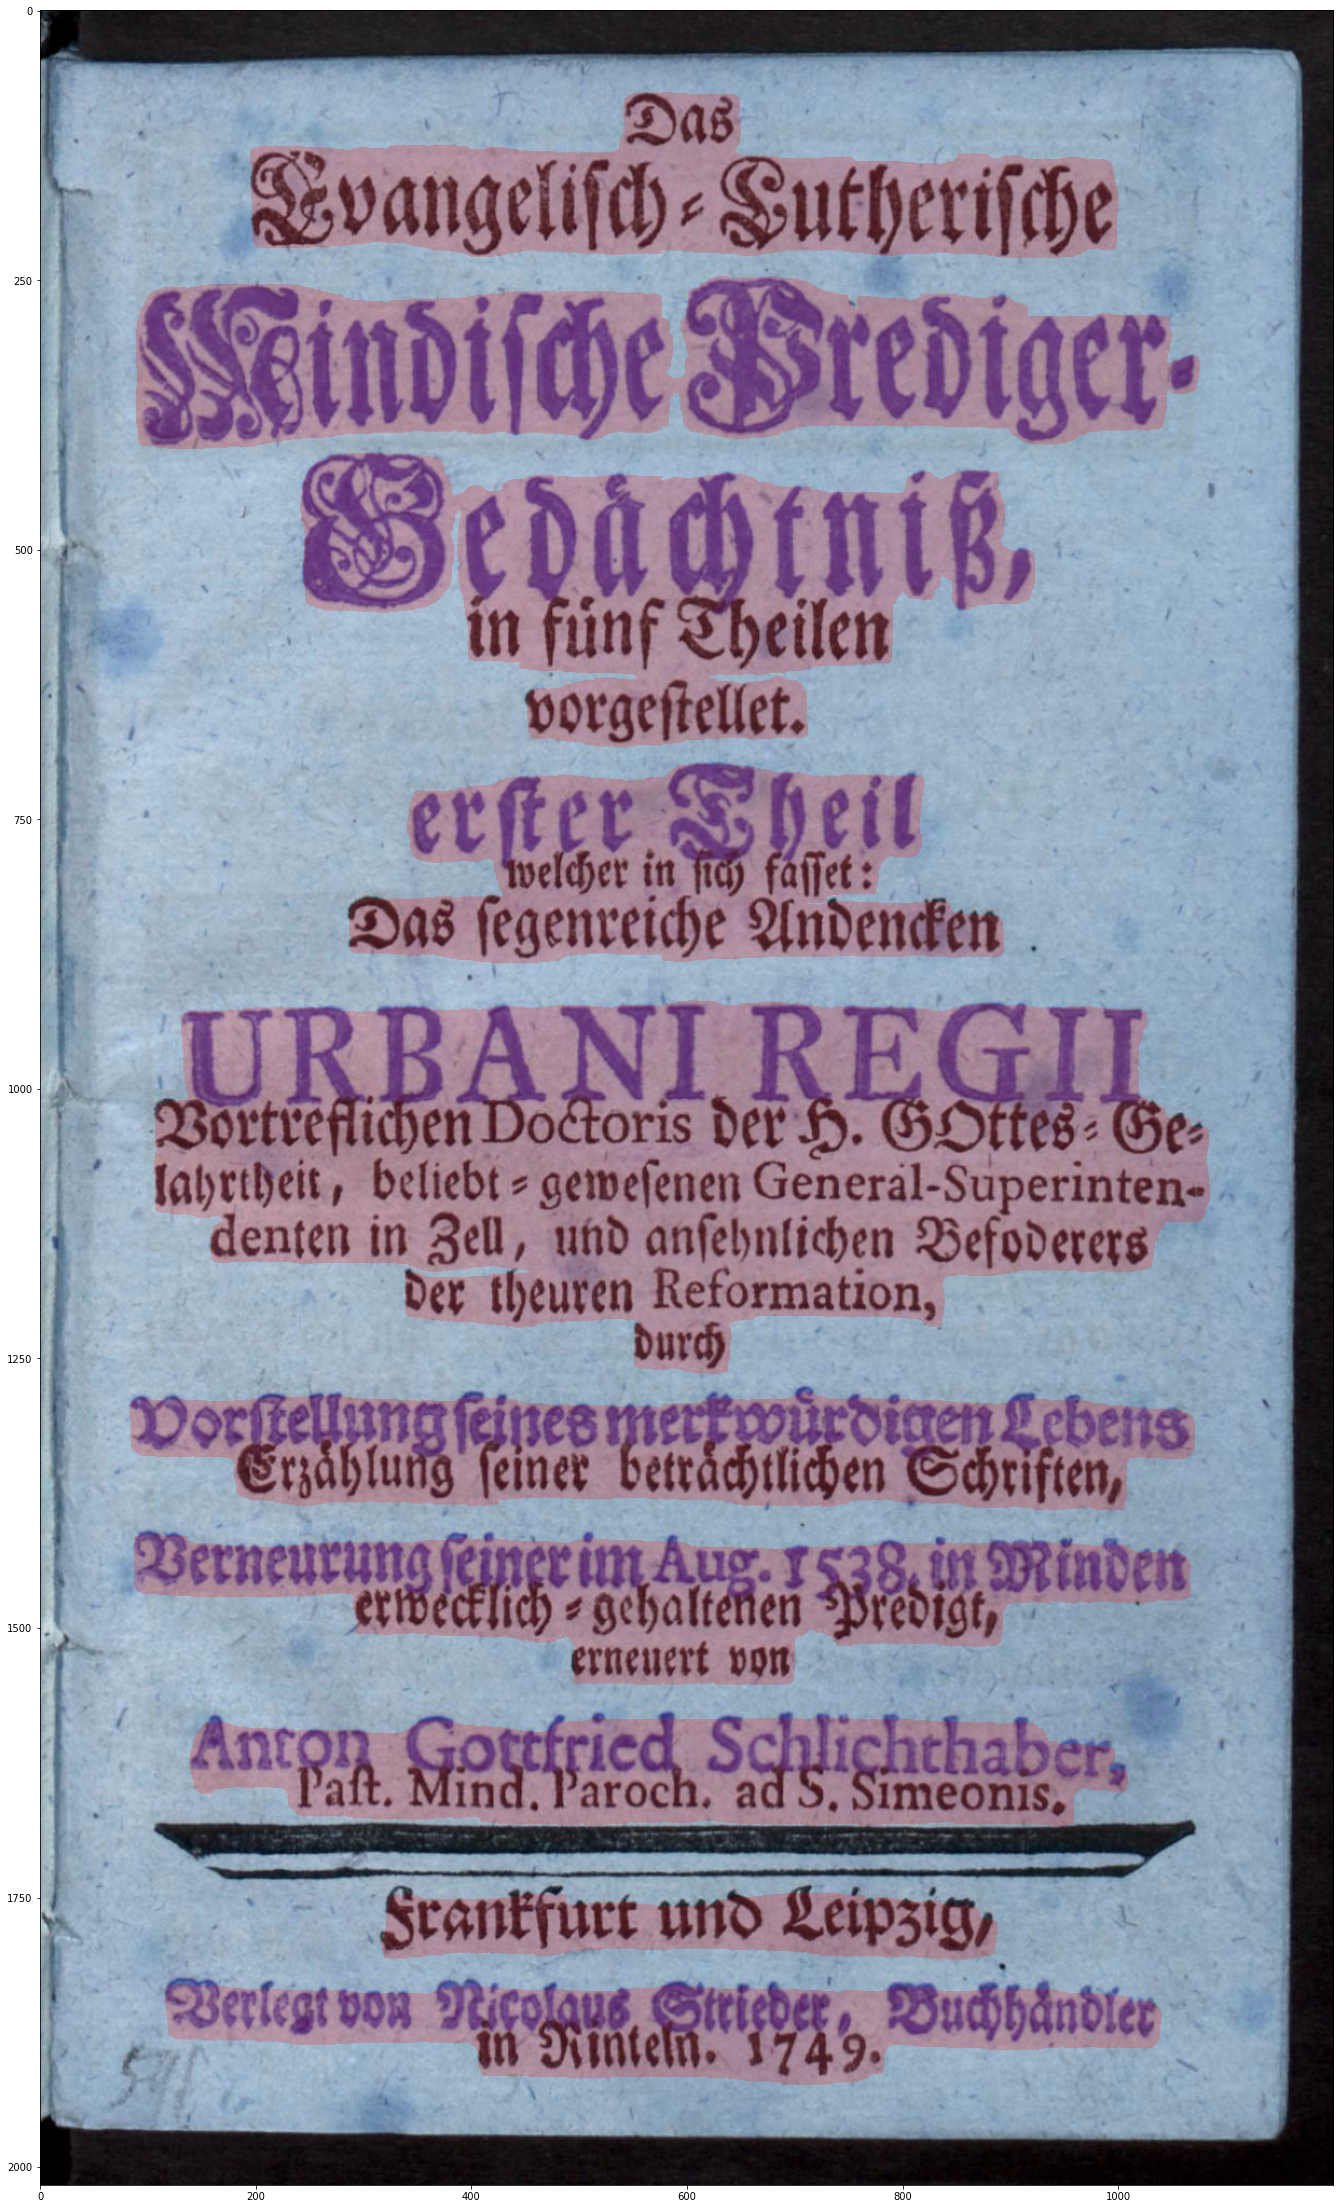

In [6]:
dir_of_xml_data = 'PPN798786388_00000005.xml'
dir_of_image = 'PPN798786388_00000005.jpg'
experiment = 'layout'
run_every_thing (dir_of_xml_data,dir_of_image,experiment )

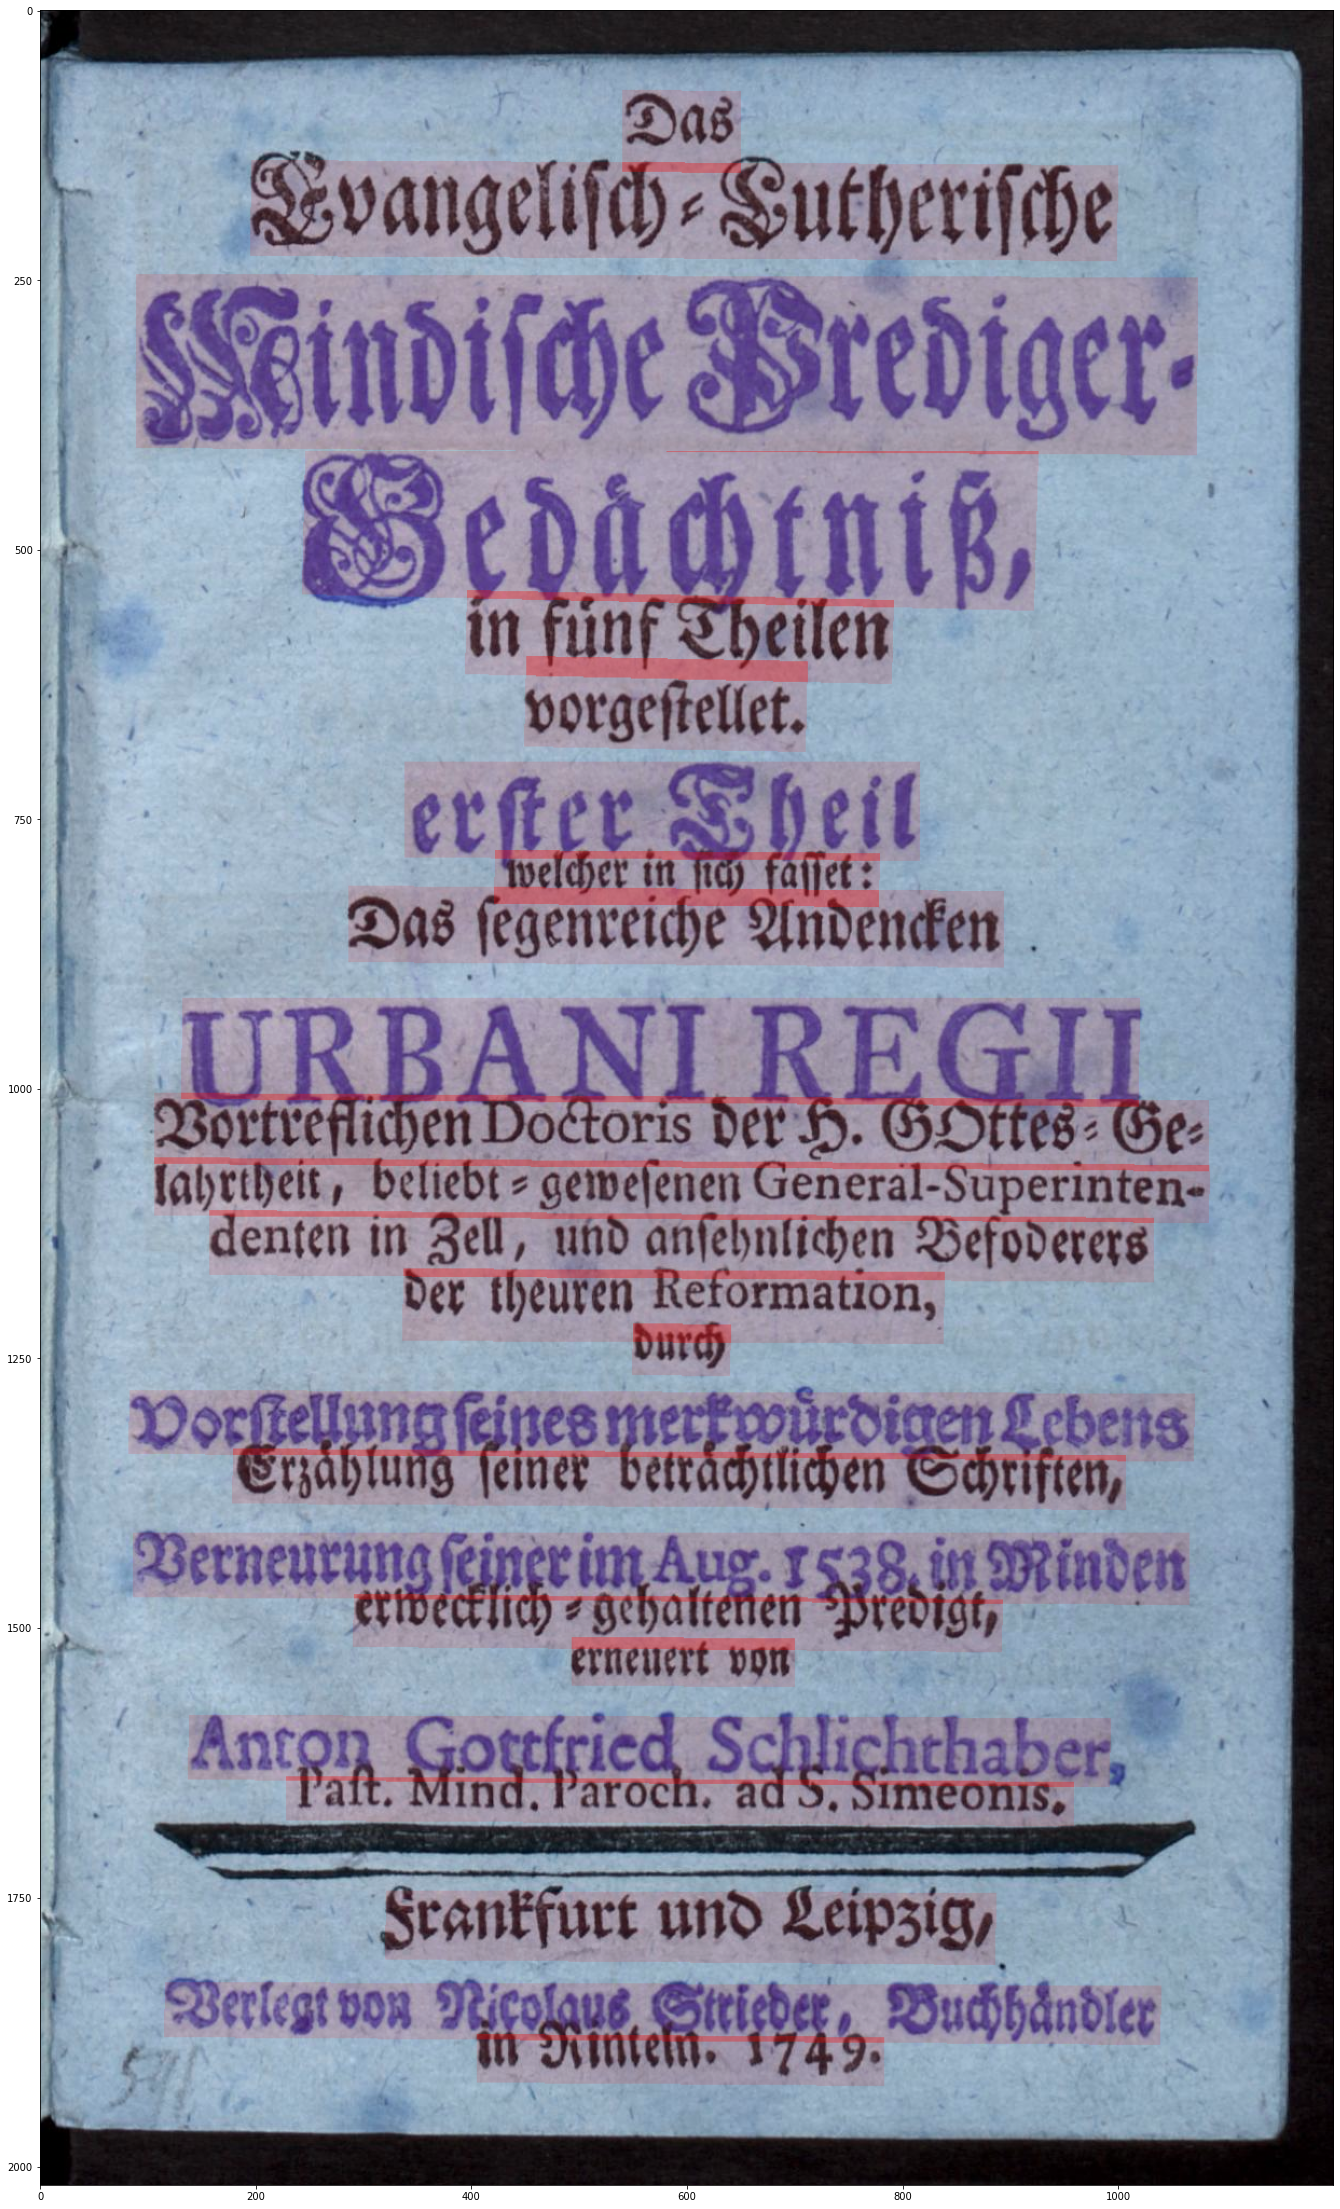

In [7]:
experiment = 'textline' # or "layout"
run_every_thing (dir_of_xml_data, dir_of_image , experiment )